# Plot fairness profile

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator  #, FormatStrFormatter
import matplotlib.colors as plt_colors
plt.style.use('seaborn')
%matplotlib inline

import numpy as np
import sklearn.metrics as sk_metrics
import scipy.interpolate as sp_inter

import pickle
import sys

In [2]:
def progress_bar(step, total):
    sys.stdout.write('\r')
    sys.stdout.write("[%-99s] %2.d%%" % ('='*step, total))
    sys.stdout.flush()

In [3]:
################################################################################

# Trial
# task_id, flow_id, fold_id = 31, 5889, 0
task_id, flow_id, fold_id = 31, 66, 0

##########     ##########     ##########     ##########     ##########

# Fairness
## Top-performing pipeline for each data set (i.e., task)
### Supervised Classification on credit-approval # Gradient Boosting
# task_id, flow_id, fold_id = 29, 12736, 0
### Supervised Classification on credit-g # Ranger Classifier
# task_id, flow_id, fold_id = 31, 6794, 0
### Supervised Classification on adult # Boosting with Decision Trees
# task_id, flow_id, fold_id = 7592, 6970, 0

##########     ##########     ##########     ##########     ##########

# Compare the influence of the shape of decision boundaries
# task_id, flow_id, fold_id = 31, 1720, 0  # weka.J48 (decision tree) <- 22
# task_id, flow_id, fold_id = 31, 66, 0    # weka.IBk (k-nearest neighbours) <- 13
# task_id, flow_id, fold_id = 31, 1820, 0  # weka.MultilayerPerceptron <- 12
## task_id, flow_id, fold_id = 31, 5920, 0  # weka.MultilayerPerceptron <- xx
# task_id, flow_id, fold_id = 31, 70, 0    # weka.SMO_PolyKernel (SVM) <- 15
# task_id, flow_id, fold_id = 31, 72, 0    # weka.SMO_RBFKernel (SVM) <- 33
# task_id, flow_id, fold_id = 31, 1726, 0  # weka.RandomForest <- 20

################################################################################

In [4]:
DELTA = 2  # Round the performance to the n-th decimal place (int or None)

LIMIT_PERFORMANCE_BANDS = False  # plot only the first few performance bands

PRINT_TOY_DATA = False  # Use the toy data instead of real data

# first plot
SKIP_ZEROS = True  # don't plot 0 bars height-wise
TICK_TOCK = False  # staggered x-labels

# second plot
SANS_GROUND_TRUTH = True  # use just uniqueness of predictions without needing the ground truth for fairness validation set
if task_id == 7592 and True:
    FILTER_INSTANCES = 125  # filter only 125*2 (top and bottom) instances that are treated unfair
else:
    FILTER_INSTANCES = 0
TICK_TOCK_Y = False  # staggered y-labels

In [5]:
task_file = f'./run_cache/{task_id}/{task_id}_{flow_id}.pickle'

with open(task_file, 'br') as f:
    dict_ = pickle.load(f)
    labels = dict_['labels']
    predictions = dict_['runs']

In [6]:
print('Number of runs in the flow--fold:',
      len(predictions[flow_id][fold_id]))

Number of runs in the flow--fold: 13


In [7]:
print('Number of instances in the test fold/data:',
      predictions[flow_id][fold_id][0].shape[0])

Number of instances in the test fold/data: 100


In [8]:
# group predictions by accuracy level
per_metric = dict()

for pred in predictions[flow_id][fold_id]:
    y_acc = sk_metrics.accuracy_score(labels[fold_id].astype(pred.dtype), pred)
    if DELTA:
        y_acc = np.around(y_acc, decimals=DELTA)

    pred_list = pred.tolist()
    
    if y_acc in per_metric:
        per_metric[y_acc].append(pred_list)
    else:
        per_metric[y_acc] = [pred_list]

In [9]:
performance_bands_number = len(per_metric.keys())

print('Number of unique performance bands:', performance_bands_number)

Number of unique performance bands: 6


In [10]:
# find unique predictions allocations for each performance band
fairness_profile = dict()

for m in per_metric:
    # 1. concat into columns of a single matrix
    profile = np.column_stack(per_metric[m])
    # 2. compute unique columns
    _, profile_counts = np.unique(profile, axis=1, return_counts=True)
    
    assert m not in fairness_profile
    fairness_profile[m] = profile_counts.tolist()

In [11]:
# Toy example form the paper -- 50 + 50 Gaussian
# interesting indices
#     * border red indice top-right   : 25
#     * border red indice bottom-right: 13
#     * border red indices top-left   : 17, 42
#     * border red indice centre      : 31
#
#     * border blue indice edge-top   : 53
#     * border blue indice edge-centre: 77
#     * border blue indice edge-bottom: 68
#     * border blue indices edge-far  : 51, 87
#     * border blue indice centre     : 94
if PRINT_TOY_DATA:
    #
    # fairness_profile = {0.55: [22, 17, 33],
    #                     0.75: [11, 3],
    #                     0.8: [12, 5, 7, 12],
    #                     0.95: [15]}
    fairness_profile = {1.00: [3],
                        0.99: [2, 2, 3, 1, 1, 1],  # line + 1-NN
                        0.98: [2, 2, 1, 1, 1, 1]}  # line + poly
    labels = {fold_id: np.asarray(50*[0] + 50*[1])}
    predictions = {flow_id: {fold_id: [
        # acc: 1.0
        np.asarray(50*[0] + 50*[1]),
        np.asarray(50*[0] + 50*[1]),
        np.asarray(50*[0] + 50*[1]),
        # acc: 0.99 -- line
        np.asarray(25*[0] + [1] + 24*[0] + 50*[1]),  # red
        np.asarray(13*[0] + [1] + 36*[0] + 50*[1]),  # red
        np.asarray(50*[0] + 3*[1] + [0] + 46*[1]),  # blue
        np.asarray(50*[0] + 27*[1] + [0] + 22*[1]),  # blue
        # acc: 0.99 -- 1-NN
        np.asarray(25*[0] + [1] + 24*[0] + 50*[1]),  # red
        np.asarray(31*[0] + [1] + 18*[0] + 50*[1]),  # red
        np.asarray(50*[0] + 27*[1] + [0] + 22*[1]),  # blue
        np.asarray(50*[0] + 44*[1] + [0] + 5*[1]),  # ble
        # acc: 0.98 -- line
        np.asarray(13*[0] + [1] + 11*[0] + [1] + 24*[0] + 50*[1]),  # red
        np.asarray(13*[0] + [1] + 36*[0] + 3*[1] + [0] + 46*[1]),  # mix
        np.asarray(50*[0] + 3*[1] + [0] + 23*[1] + [0] + 22*[1]),  # blue
        np.asarray(50*[0] + 18*[1] + [0] + 8*[1] + [0] + 22*[1]),  # blue
        # acc: 0.98 -- poly
        np.asarray(13*[0] + [1] + 11*[0] + [1] + 24*[0] + 50*[1]),  # red
        np.asarray(17*[0] + [1] + 24*[0] + [1] + 7*[0] + 50*[1]),  # red
        np.asarray(50*[0] + 3*[1] + [0] + 23*[1] + [0] + 22*[1]),  # blue
        np.asarray(50*[0] + [1] + [0] + 35*[1] + [0] + 12*[1]),  # blue
        # acc: 0.99 -- tree
        np.asarray(50*[0] + 3*[1] + [0] + 46*[1]),  # index 53
        np.asarray(50*[0] + 3*[1] + [0] + 46*[1]),  # index 53
        ]}}

## Un-normalised Smooth

In [12]:
labels_fig = np.flip(np.sort(
    list(fairness_profile.keys())))  # max --to--> min (performance metric)

data = [
    sorted(fairness_profile[l])[::-1] for l in labels_fig
]  # counts per performance band
labels_fig = [f'{i:.2f}' for i in labels_fig]  # prettify

# get top height
bin_numbers = max([len(i) for i in data])
max_val = np.max(data)

# pad the counts with 0s
data_padded = []
for d in data:
    data_padded.append(np.asarray(
        d + ([0] * (bin_numbers - len(d)))
    ))

/Users/kacper/.pyenv/versions/3.8.2/envs/openml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [13]:
# get mid-points on the x-axis for each performance band
binned_maximums = np.max(data_padded, axis=1)
x_locations = [0]
for i in binned_maximums:
    x_locations.append(x_locations[-1] + i)
x_locations = 0.5 * (x_locations + np.roll(x_locations, -1))[:-1]

In [14]:
# colours = plt.rcParams['axes.prop_cycle'].by_key()['color']

cc = plt.get_cmap('tab10')  # Set3
colours = [plt_colors.rgb2hex(cc(i)) for i in range(cc.N)]

# loop colours ot have enough of them
colours = (int(performance_bands_number / len(colours)) + 1) * colours

In [15]:
# get plot range for the y-axis
custom_range = np.arange(
    0,
    bin_numbers,
    1
)
custom_range_smooth = np.linspace(
    0,
    bin_numbers - 1,
    bin_numbers * 100
)

In [16]:
data_smooth = []

for d in data_padded:
    smooth = sp_inter.PchipInterpolator(custom_range, d)
    data_smooth.append(
        smooth(custom_range_smooth))

In [17]:
if LIMIT_PERFORMANCE_BANDS:
    # res_ = 16  # 3, 2, 16
    if task_id == 29:
        res_ = 3
    elif task_id == 31:
        res_ = 2
    elif task_id == 7592:
        res_ = 16
    else:
        assert False, 'Cannot extract top performance bands'

    # stability profile profile
    x_locations_ = x_locations[:res_]
    data_padded_ = data_padded[:res_]
    data_smooth_ = data_smooth[:res_]

    data_ = data[:res_]
else:
    # stability profile profile
    x_locations_ = x_locations
    data_padded_ = data_padded
    data_smooth_ = data_smooth

    data_ = data

In [18]:
print('Total workflow runs to be plotted:',
    sum([sum(i) for i in data_]),
    '   (out of', len(predictions[flow_id][fold_id]), ')'
)

Total workflow runs to be plotted: 13    (out of 13 )


[====================================================================================================] 100%

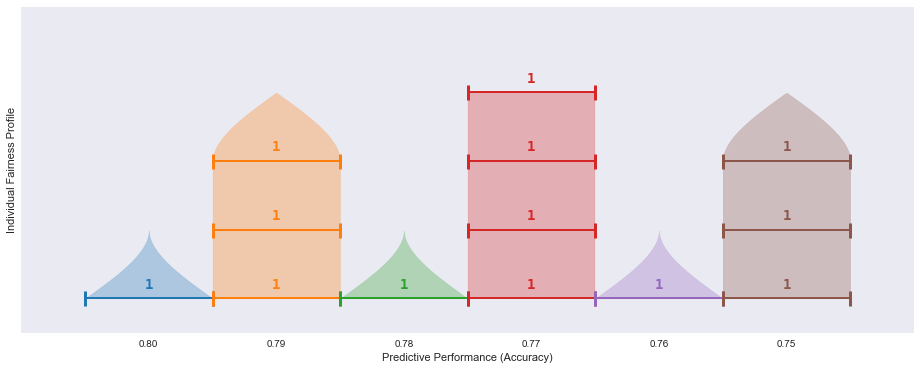

In [19]:
size_ = (16, 6)

if task_id == 29 and flow_id == 12736 and fold_id == 0:
    SKIP_ZEROS = True
    size_ = (8, 10)
elif task_id == 31 and flow_id == 6794 and fold_id == 0:
    SKIP_ZEROS = True
    size_ = (8, 10)
elif task_id == 7592 and flow_id == 6970 and fold_id == 0 and DELTA == 2:
    SKIP_ZEROS = True
    TICK_TOCK = False
    size_ = (10, 35)
elif task_id == 7592 and flow_id == 6970 and fold_id == 0:
    SKIP_ZEROS = True
    TICK_TOCK = True
    size_ = (8, 10)

f = plt.figure(figsize=size_)  # 24, 24 # , 3 # 16, 6

x_limits = []

i_max = len(x_locations_)
progress_bar(0, 0)
#
for i, (x_loc, custom_d, d, d_) in enumerate(zip(x_locations_, data_smooth_, data_padded_, data_)):
    # body
    c = i % len(colours)
    if SKIP_ZEROS:
        i_lim = custom_d.astype(bool).sum()
        custom_range_smooth_ = custom_range_smooth[:i_lim]
        custom_d_ = custom_d[:i_lim]
    else:
        custom_range_smooth_ = custom_range_smooth
        custom_d_ = custom_d
    plt.fill_betweenx(custom_range_smooth_,
                      x_loc-.5*custom_d_, x_loc+.5*custom_d_,
                      color=colours[c], alpha=0.3)
    x_limits += [x_loc-.5*custom_d_, x_loc+.5*custom_d_]

    # bars
    #plt.hlines(y=custom_range,
    #           xmin=x_loc-.5*d, xmax=x_loc+.5*d,
    #           style='-o',
    #           linewidth=3, color=colours[c])
    for a, b in zip(custom_range, d):
        if b == 0 and SKIP_ZEROS:  # skip labelling 0's
            continue
        plt.plot([x_loc-.5*b, x_loc+.5*b], [a, a], '-|',
                 solid_capstyle='butt',
                 markersize=15, markeredgewidth=3,
                 color=colours[c], linewidth=2)
    
    for j, j_label in enumerate(d_):  # data[i]
        if j_label == 0 and SKIP_ZEROS:  # skip labelling 0's
            continue
        plt.text(x_loc, j+.15, j_label, color=colours[c],
                 fontfamily='monospace', fontweight='extra bold', fontsize=14,
                 horizontalalignment='center')

    prog_ = int(100*i/(i_max))
    progress_bar(prog_, prog_)
progress_bar(100, 100)

plt.yticks([])

if TICK_TOCK:
    f.axes[0].xaxis.set_major_locator(FixedLocator(x_locations_[0::2]))  # even
    f.axes[0].xaxis.set_minor_locator(FixedLocator(x_locations_[1::2]))  # odd
    f.axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda _, loc: labels_fig[0::2][loc]))
    f.axes[0].xaxis.set_minor_formatter(plt.FuncFormatter(lambda _, loc: labels_fig[1::2][loc]))  # FormatStrFormatter("%d"))
    f.axes[0].tick_params(which='minor', pad=18, axis='x')
    # f.axes[0].xaxis.set_label_text(labels)
else:
    plt.xticks(x_locations_, labels_fig)

plt.xlabel('Predictive Performance (Accuracy)')
plt.ylabel('Individual Fairness Profile')

y_min, y_max = f.axes[0].get_ylim()
# plt.ylim((y_min, y_max + 0.5))
#
# plt.ylim((-.5, max([len(i) for i in data]) - 0.25))
if task_id == 7592 and flow_id == 6970 and fold_id == 0 and LIMIT_PERFORMANCE_BANDS:
    plt.ylim((-.05, 3.05))
else:
    plt.ylim((-.5, max([len(i) for i in data_]) + 0.25))
# plt.ylim((-.5, max([i.astype(bool).sum() for i in data_padded_]) + 0.25))

plt.xlim((x_locations_[0] - 0.5 * data_smooth_[0].max() - .5,
          x_locations_[-1] + 0.5 * data_smooth_[-1].max() + .5))

plt.grid(visible=None)

if PRINT_TOY_DATA:
    fig_path = f'../figure/model_profile_toy_16_3.pdf'  # 16, 3
else:
    fig_path = f'../figure/model_profile_{task_id}_{flow_id}_{fold_id}_{DELTA}.pdf'

# plt.show()
plt.savefig(
    fig_path,
    dpi=300,
    bbox_inches='tight',
    pad_inches=0)

## Per-instance visualisation

In [20]:
# get data for per-instance visualisation
y_sort_idx = np.argsort(labels[fold_id])

one_value = np.unique(labels[fold_id])
assert one_value.shape[0] == 2
one_value = one_value[0]

individual_profile = dict()

for pred in predictions[flow_id][fold_id]:
    y = labels[fold_id].astype(pred.dtype)
    y_ = pred

    y_acc = sk_metrics.accuracy_score(y, y_)
    if DELTA:
        y_acc = np.around(y_acc, decimals=DELTA)

    if SANS_GROUND_TRUTH:
        y_sort_idx_ = np.argsort(y)
        assert np.equal(y_sort_idx, y_sort_idx_).all()

        y_comp = y_[y_sort_idx] == one_value  # .astype(bool)
    else:
        y_comp = y == y_
    
    if y_acc in individual_profile:
        individual_profile[y_acc].append(y_comp)
    else:
        individual_profile[y_acc] = [y_comp]

metric_values = sorted(individual_profile.keys())[::-1]

In [21]:
# filter metric values if decided
if LIMIT_PERFORMANCE_BANDS:
    metric_values = metric_values[:res_]

In [22]:
alltogether = []
for i in metric_values:  # individual_profile:
    alltogether += individual_profile[i]

filter_diff = np.logical_not(np.logical_or(
    np.all(np.asarray(alltogether), axis=0),
    np.all(np.logical_not(np.asarray(alltogether)), axis=0)
))

print('Data points that are unfair across the investigated performance bands:',
      filter_diff.sum(), 'out of', filter_diff.shape[0])

Data points that are unfair across the investigated performance bands: 30 out of 100


In [23]:
individual_profile_count = dict()
y_ticks = dict()

for i in metric_values:
    # restrict to instaces that are affected
    if FILTER_INSTANCES:
        per1 = (np.asarray(individual_profile[i])[:, filter_diff])[:, :FILTER_INSTANCES]
        per2 = (np.asarray(individual_profile[i])[:, filter_diff])[:, -FILTER_INSTANCES:]
        per = np.hstack([per1, per2])
        # per = (np.asarray(individual_profile[i])[:, filter_diff])[:, :250]
    else:
        per = np.asarray(individual_profile[i])

    prof = per.shape[0] - per.sum(axis=0)  # per == per.dtype.type(ref_val)

    individual_profile_count[i] = prof
    y_ticks[i] = per.shape[0]

### Left-aligned plot

[====================================================================================================] 100%
--> pre plot <--


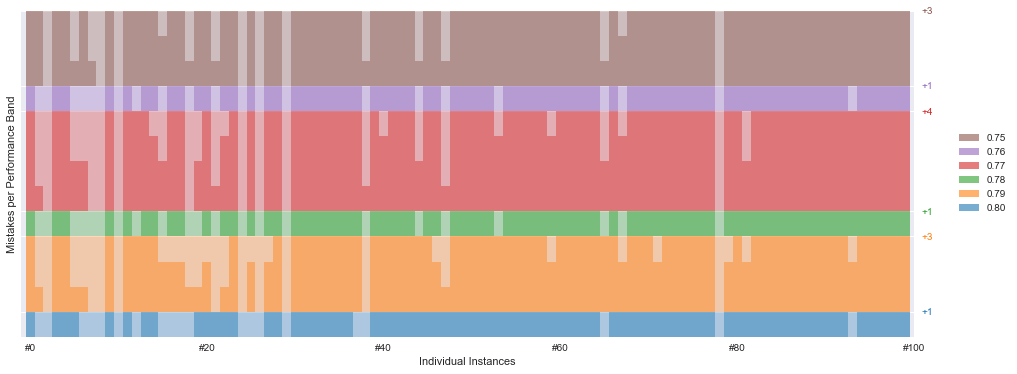

In [24]:
# TODO: use polygon collections to speed up plotting
# https://matplotlib.org/3.1.1/gallery/misc/histogram_path.html
# https://matplotlib.org/stable/api/collections_api.html
# https://stackoverflow.com/questions/53989321/matplotlib-pyplot-savefig-takes-really-long-time

# TICK_TOCK_Y = True  # 12
f = plt.figure(figsize=(16, 6))  # , 6 # , 3

y = np.vstack(
    [individual_profile_count[i] for i in metric_values])
x = np.asarray(range(y.shape[1]))

x_loc_f = np.cumsum([y_ticks[i] for i in metric_values])
x_lab_f = [f'+{y_ticks[i]}' for i in metric_values]

# actual plot
# plt.stackplot(
#     x, y,
#     labels=[f'{i:.2f}' for i in metric_values],
#     colors=colours)  # y1, y2, y3
#
labels_ = [f'{i:.2f}' for i in metric_values]
heights_ = [y_ticks[i] for i in metric_values]
for i in range(y.shape[0]):
    # bottom_ = None if i == 0 else y[:i,:].sum(axis=0)
    # plt.bar(x, y[i,:], 1, label=labels_[i], color=colours[i], bottom=bottom_)
    #
    bottom_ = None if i == 0 else x_loc_f[i-1]
    bottom_1_ = y[i,:] if i == 0 else x_loc_f[i-1] + y[i,:]
    plt.bar(x, y[i,:], 1, label=labels_[i], color=colours[i], alpha=0.6, bottom=bottom_, linewidth=0)#, rasterized=True
    plt.bar(x, heights_[i]-y[i,:], 1, color=colours[i], alpha=0.3, bottom=bottom_1_, linewidth=0)# , rasterized=True

    prog_ = int(100*i/y.shape[0])
    progress_bar(prog_, prog_)
progress_bar(100, 100)
# actual plot

handles_, labels_ = f.axes[0].get_legend_handles_labels()
plt.legend(handles_[::-1], labels_[::-1], bbox_to_anchor=(1.04, .5), loc='center left')  # loc='upper left')

### f.axes[0].tick_params(axis='y', colors='purple')
#
#
if TICK_TOCK_Y:
    f.axes[0].yaxis.set_major_locator(FixedLocator(x_loc_f[0::2]))  # even
    f.axes[0].yaxis.set_minor_locator(FixedLocator(x_loc_f[1::2]))  # odd
    f.axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda _, loc: x_lab_f[0::2][loc]))
    f.axes[0].yaxis.set_minor_formatter(plt.FuncFormatter(lambda _, loc: x_lab_f[1::2][loc]))
    f.axes[0].tick_params(which='minor', pad=20, axis='y')
else:
    plt.yticks(x_loc_f, x_lab_f)
#
f.axes[0].yaxis.tick_right()
#
if TICK_TOCK_Y:
    # for ticklabel, tickcolor in zip(f.axes[0].get_yticklabels(), colours):  # plt.gca().get_yticklabels()
    ticks_ = []
    maj_ = f.axes[0].get_yticklabels(which='major')
    min_ = f.axes[0].get_yticklabels(which='minor')
    for i in range(len(x_loc_f)):
        if i%2 == 0:
            i_ = maj_[int(i/2)]
        else:
            i_ = min_[int(i/2)]
        ticks_.append(i_)
    for ticklabel, tickcolor in zip(ticks_, colours):
        ticklabel.set_color(tickcolor)
else:
    for ticklabel, tickcolor in zip(f.axes[0].get_yticklabels(), colours):
        ticklabel.set_color(tickcolor)

f.axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, _: f'#{val:.0f}'))

plt.grid(visible=True, which='minor', axis='y')
plt.grid(visible=False, which='both', axis='x')

plt.xlabel('Individual Instances')
plt.ylabel('Mistakes per Performance Band')

plt.xlim((-1,
          y.shape[1]))

if PRINT_TOY_DATA:
    fig_path = f'../figure/prediction_profile_toy_16_3_{SANS_GROUND_TRUTH}.pdf'  # 16, 3
else:
    fig_path = f'../figure/prediction_profile_{task_id}_{flow_id}_{fold_id}_{SANS_GROUND_TRUTH}_{DELTA}.pdf'  # _16_3

print('\n--> pre plot <--')

# plt.show()
plt.savefig(
    fig_path,
    dpi=300,
    bbox_inches='tight',
    pad_inches=0)

### Precise plot

[====================================================================================================] 100%
--> pre plot <--


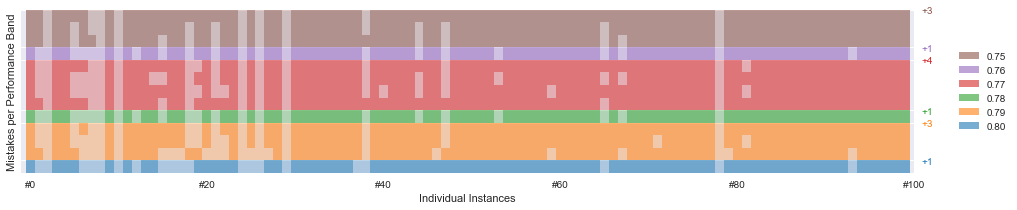

In [25]:
f = plt.figure(figsize=(16, 3))  # 16, 16

x_loc_f = np.cumsum([y_ticks[i] for i in metric_values])
x_lab_f = [f'+{y_ticks[i]}' for i in metric_values]

labels_ = [f'{i:.2f}' for i in metric_values]
heights_ = [y_ticks[i] for i in metric_values]
height_ = 0
max_i = sum([len(individual_profile[i]) for i in metric_values])
for i, i_a in enumerate(metric_values):
    for j, j_a in enumerate(individual_profile[i_a]):
        ll = labels_[i] if j == 0 else None
        plt.bar(x, np.logical_not(j_a), 1, label=ll, color=colours[i], alpha=0.6, bottom=height_, linewidth=0, edgecolor=colours[i], rasterized=True)
        plt.bar(x, j_a, 1, color=colours[i], alpha=0.3, bottom=height_, linewidth=0, edgecolor=colours[i], rasterized=True)

        prog_ = int(100*height_/max_i)
        progress_bar(prog_, prog_)

        height_ += 1
progress_bar(100, 100)
# actual plot

handles_, labels_ = f.axes[0].get_legend_handles_labels()
plt.legend(handles_[::-1], labels_[::-1], bbox_to_anchor=(1.04, .5), loc='center left')  # loc='upper left')

### f.axes[0].tick_params(axis='y', colors='purple')
#
#
if TICK_TOCK_Y:
    f.axes[0].yaxis.set_major_locator(FixedLocator(x_loc_f[0::2]))  # even
    f.axes[0].yaxis.set_minor_locator(FixedLocator(x_loc_f[1::2]))  # odd
    f.axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda _, loc: x_lab_f[0::2][loc]))
    f.axes[0].yaxis.set_minor_formatter(plt.FuncFormatter(lambda _, loc: x_lab_f[1::2][loc]))
    f.axes[0].tick_params(which='minor', pad=20, axis='y')
else:
    plt.yticks(x_loc_f, x_lab_f)
#
f.axes[0].yaxis.tick_right()
#
if TICK_TOCK_Y:
    # for ticklabel, tickcolor in zip(f.axes[0].get_yticklabels(), colours):  # plt.gca().get_yticklabels()
    ticks_ = []
    maj_ = f.axes[0].get_yticklabels(which='major')
    min_ = f.axes[0].get_yticklabels(which='minor')
    for i in range(len(x_loc_f)):
        if i%2 == 0:
            i_ = maj_[int(i/2)]
        else:
            i_ = min_[int(i/2)]
        ticks_.append(i_)
    for ticklabel, tickcolor in zip(ticks_, colours):
        ticklabel.set_color(tickcolor)
else:
    for ticklabel, tickcolor in zip(f.axes[0].get_yticklabels(), colours):
        ticklabel.set_color(tickcolor)

f.axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, _: f'#{val:.0f}'))

plt.grid(visible=True, which='minor', axis='y')
plt.grid(visible=False, which='both', axis='x')

plt.xlabel('Individual Instances')
plt.ylabel('Mistakes per Performance Band')

plt.xlim((-1, y.shape[1]))
plt.ylim((0, height_))

print('\n--> pre plot <--')

if PRINT_TOY_DATA:
    fig_path = f'../figure/prediction_profile_toy_16_3_{SANS_GROUND_TRUTH}_.pdf'  # 16, 3
else:
    fig_path = f'../figure/prediction_profile_{task_id}_{flow_id}_{fold_id}_{SANS_GROUND_TRUTH}_.pdf'

# plt.show()
plt.savefig(
    fig_path,
    dpi=300,
    bbox_inches='tight',
    pad_inches=0)